In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import numpy as np
import matplotlib as mpl
import re
from fastai.tabular import *
from datetime import timedelta
import numpy as np

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df_m = pd.read_csv('gdrive/My Drive/Table.csv', header=0)
# df_m = pd.read_csv()

In [8]:
# df_m = pd.read_csv("Table.csv", header=0)
df_m.head() #(7696, 12)

,Date,Place,Ill,Trends_grypa,TempDob,TempDob_7D,Trends_kaszel,Wiatr,Opad,DobZachm,Wiglot,Opad_7D
0,2010-01-01,podkarpackie,389,701.532723,0.469231,-0.039560,701.532723,0.515385,1.145000,7.55,99.800000,2.775652
1,2010-01-01,lubelskie,128,0.000000,-2.366667,-1.056522,0.000000,0.888889,3.213636,8.00,93.200000,3.532061
2,2010-01-01,podlaskie,240,3411.804845,-5.460000,-2.457143,3411.804845,1.260000,5.995833,7.85,96.350000,4.768966
3,2010-01-01,łódzkie,2245,537.367082,-2.650000,-0.671429,1358.776160,0.575000,1.142857,8.00,94.766667,3.531000
4,2010-01-01,wielkopolskie,1410,1437.400251,-2.583333,-0.405952,928.425917,1.200000,0.960000,7.96,86.940000,2.269417


In [9]:
df_m[df_m.isnull().any(axis=1)]

,Date,Place,Ill,Trends_grypa,TempDob,TempDob_7D,Trends_kaszel,Wiatr,Opad,DobZachm,Wiglot,Opad_7D
38,2010-01-16,świętokrzyskie,14,0.000000,-6.500000,-4.871429,2781.563611,0.800000,NaN,5.000000,96.100000,2.384211
44,2010-01-16,podkarpackie,284,1627.115642,-6.600000,-3.679121,700.563749,0.823077,NaN,3.350000,92.450000,3.374194
48,2010-01-23,lubuskie,162,1640.447514,-14.900000,-6.300000,869.830999,0.000000,NaN,0.300000,82.400000,1.105634
49,2010-01-23,zachodniopomorskie,410,640.154130,-13.560000,-6.694286,1593.170290,1.980000,NaN,0.700000,70.150000,1.600000
54,2010-01-23,warmińsko-mazurskie,548,817.769618,-16.171429,-9.963265,819.268661,0.428571,NaN,2.533333,66.933333,0.969444
...,...,...,...,...,...,...,...,...,...,...,...,...
7691,2020-01-16,podkarpackie,2347,1379.214306,NaN,NaN,2175.037769,NaN,NaN,NaN,NaN,NaN
7692,2020-01-16,warmińsko-mazurskie,2264,1610.108697,NaN,NaN,3046.382767,NaN,NaN,NaN,NaN,NaN
7693,2020-01-16,łódzkie,5090,1465.552881,NaN,NaN,2890.886102,NaN,NaN,NaN,NaN,NaN
7694,2020-01-16,lubelskie,3590,2535.715616,NaN,NaN,3087.419462,NaN,NaN,NaN,NaN,NaN


In [0]:
df_m = df_m.replace({'-': 1})
df_m = df_m.replace({np.nan: 1})

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(df_m, "Date", drop=False)

In [13]:
df_m.head()

,Date,Place,Ill,Trends_grypa,TempDob,TempDob_7D,Trends_kaszel,Wiatr,Opad,DobZachm,Wiglot,Opad_7D,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2010-01-01,podkarpackie,389,701.532723,0.469231,-0.039560,701.532723,0.515385,1.145000,7.55,99.800000,2.775652,2010,1,53,1,4,1,False,True,False,True,False,True,1262304000
1,2010-01-01,lubelskie,128,0.000000,-2.366667,-1.056522,0.000000,0.888889,3.213636,8.00,93.200000,3.532061,2010,1,53,1,4,1,False,True,False,True,False,True,1262304000
2,2010-01-01,podlaskie,240,3411.804845,-5.460000,-2.457143,3411.804845,1.260000,5.995833,7.85,96.350000,4.768966,2010,1,53,1,4,1,False,True,False,True,False,True,1262304000
3,2010-01-01,łódzkie,2245,537.367082,-2.650000,-0.671429,1358.776160,0.575000,1.142857,8.00,94.766667,3.531000,2010,1,53,1,4,1,False,True,False,True,False,True,1262304000
4,2010-01-01,wielkopolskie,1410,1437.400251,-2.583333,-0.405952,928.425917,1.200000,0.960000,7.96,86.940000,2.269417,2010,1,53,1,4,1,False,True,False,True,False,True,1262304000


In [14]:
df_m.Ill = df_m.Ill.astype('float')
type(df_m.Ill.iloc[0])

numpy.float64

In [15]:
df_train = df_m.iloc[:6900]
df_test = df_m.iloc[6900:]
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

cat_vars =  ['Dayofyear',  'Year', 'Month', 'Day', 'Place']
cont_vars = ['Trends_grypa', 'TempDob', 'TempDob_7D', 'Trends_kaszel', 
             'Wiatr', 'Opad', 'DobZachm', 'Wiglot', 'Opad_7D']

dep_var = 'Ill'
df = df_train[cat_vars + cont_vars + [dep_var,'Date']].copy()
procs=[FillMissing, Categorify, Normalize]

cut = df_train['Date'][(df_train['Date'] == df_train['Date'][len(df_test)])].index.max()
valid_idx = range(cut-2)
cut
valid_idx

range(0, 797)

In [16]:
df_test['Date'].min(), df_test['Date'].max()

(Timestamp('2019-01-08 00:00:00'), Timestamp('2020-01-16 00:00:00'))

In [0]:
data = (TabularList.from_df(df, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
        .split_by_idx(valid_idx)      
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .add_test(TabularList.from_df(df_test, cat_names=cat_vars, cont_names=cont_vars))
        .databunch())

In [0]:
max_log_y = np.log(np.max(df_train['Ill'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [19]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(89, 20)
    (1): Embedding(10, 6)
    (2): Embedding(13, 7)
    (3): Embedding(5, 4)
    (4): Embedding(17, 8)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=54, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [0]:
len(data.train_ds.cont_names)

9

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


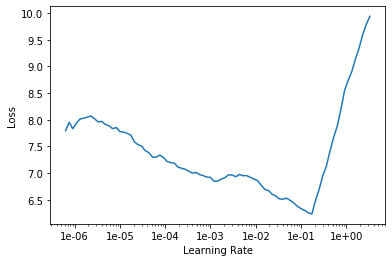

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,5.071383,6.932927,394.821136,00:01
1,1.834766,4.050176,70.034622,00:01
2,0.961260,3.877931,48.962833,00:01
3,0.670117,4.112540,55.924599,00:01
4,0.545811,3.950082,48.206345,00:01


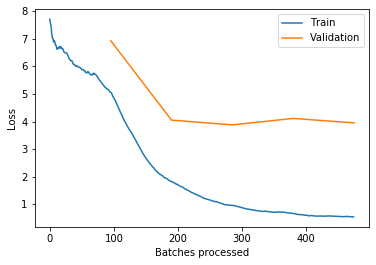

In [23]:
learn.recorder.plot_losses(skip_start=0)

In [24]:
test_preds=learn.get_preds(DatasetType.Test)
test_preds
df_test["Ill_ex"]=np.exp(test_preds[0].data).numpy().T[0]
# test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
# test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In [0]:
df_test["Date"]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


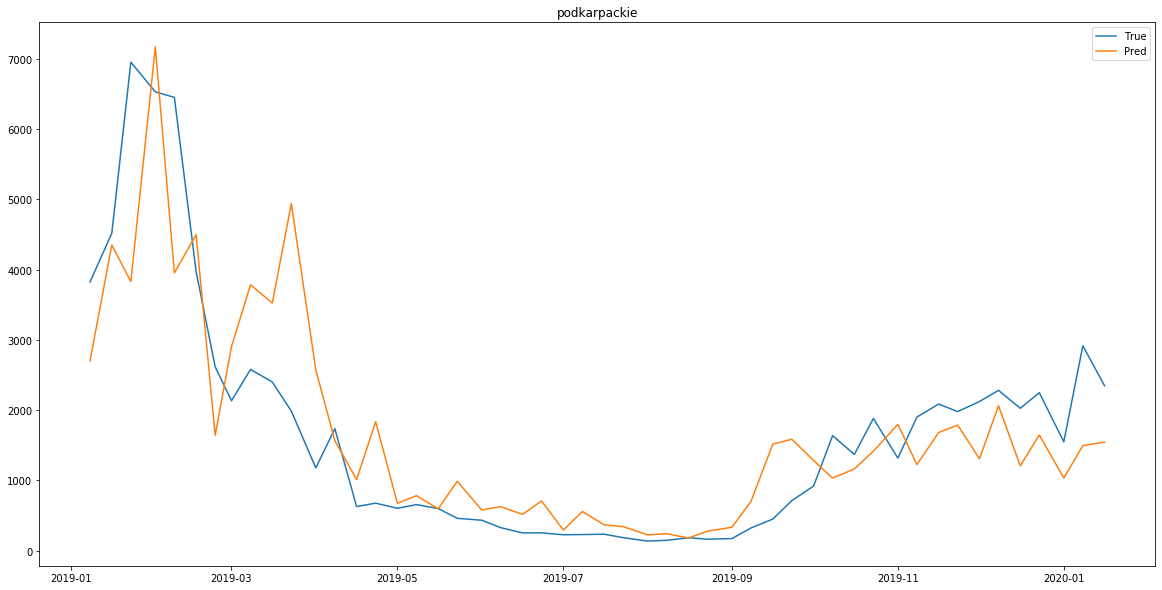

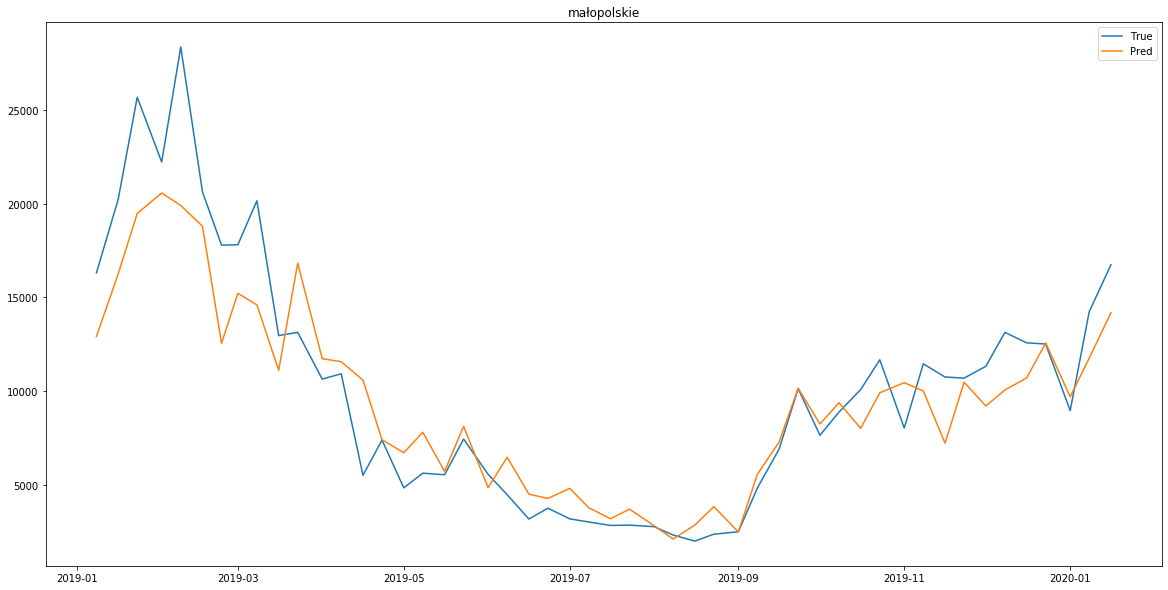

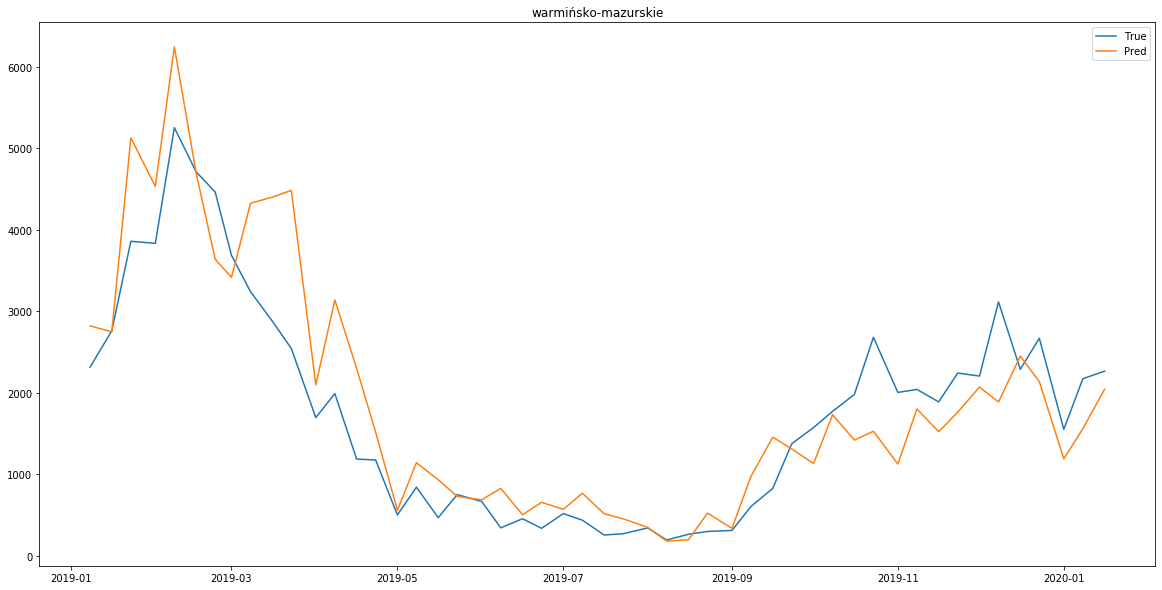

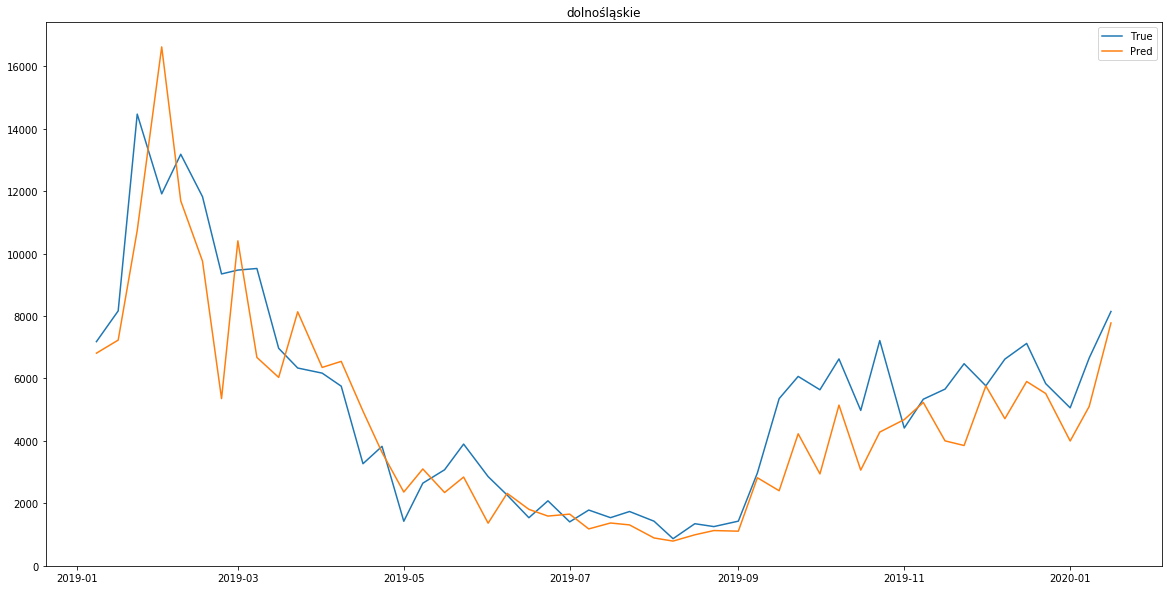

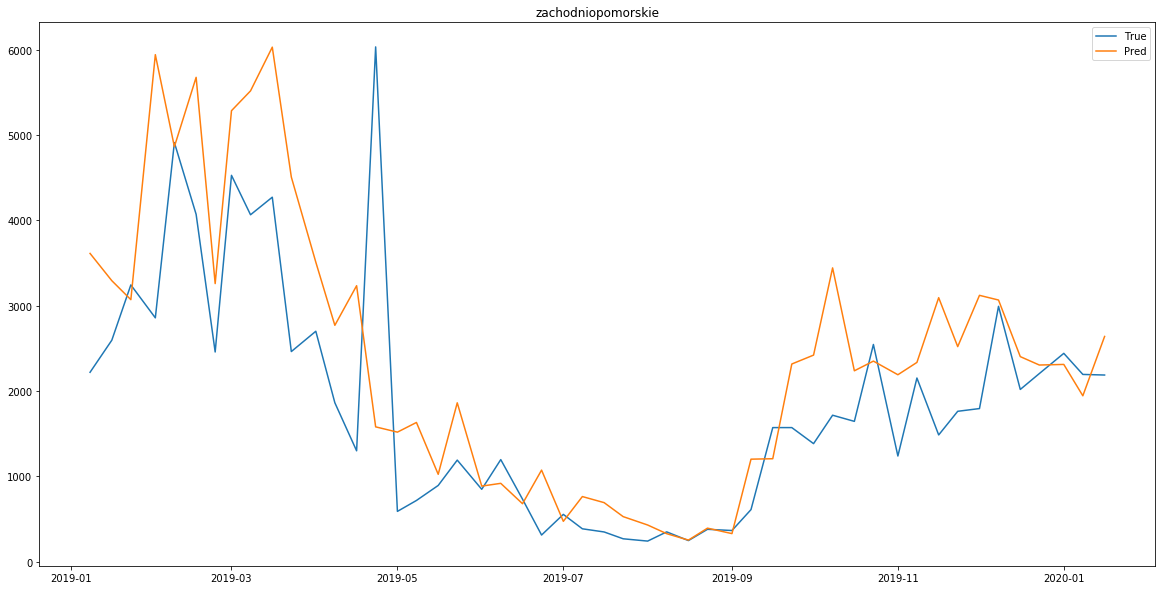

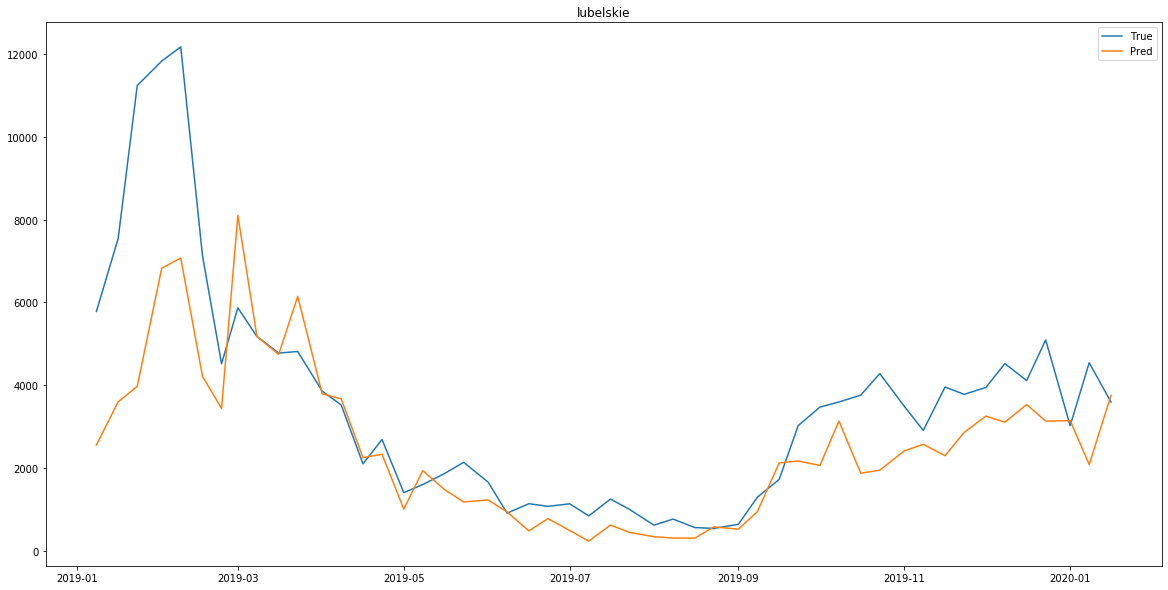

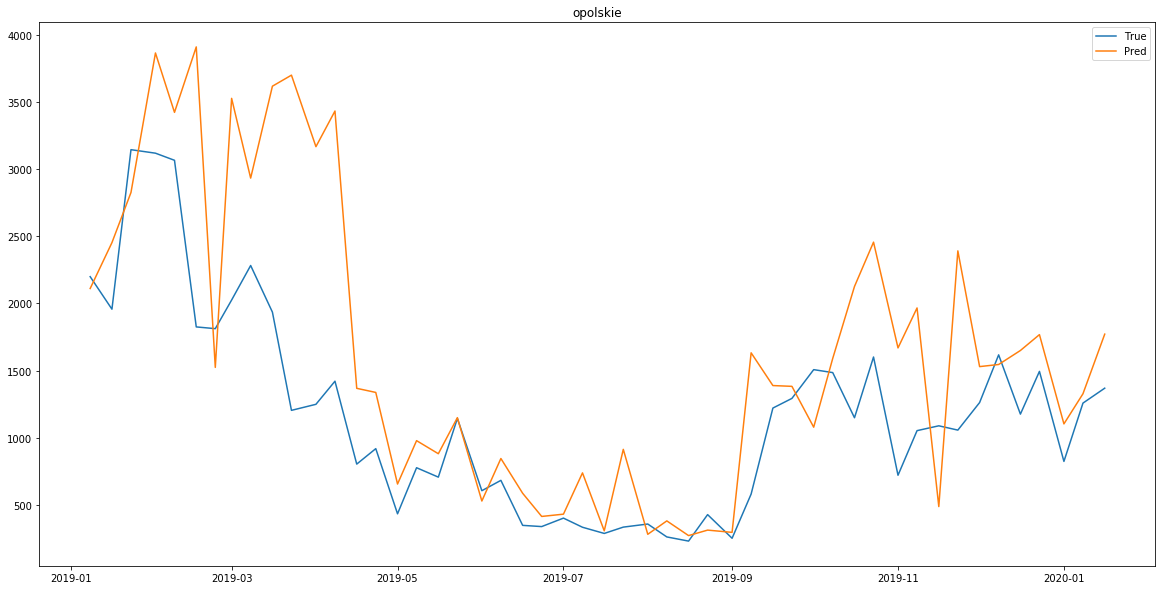

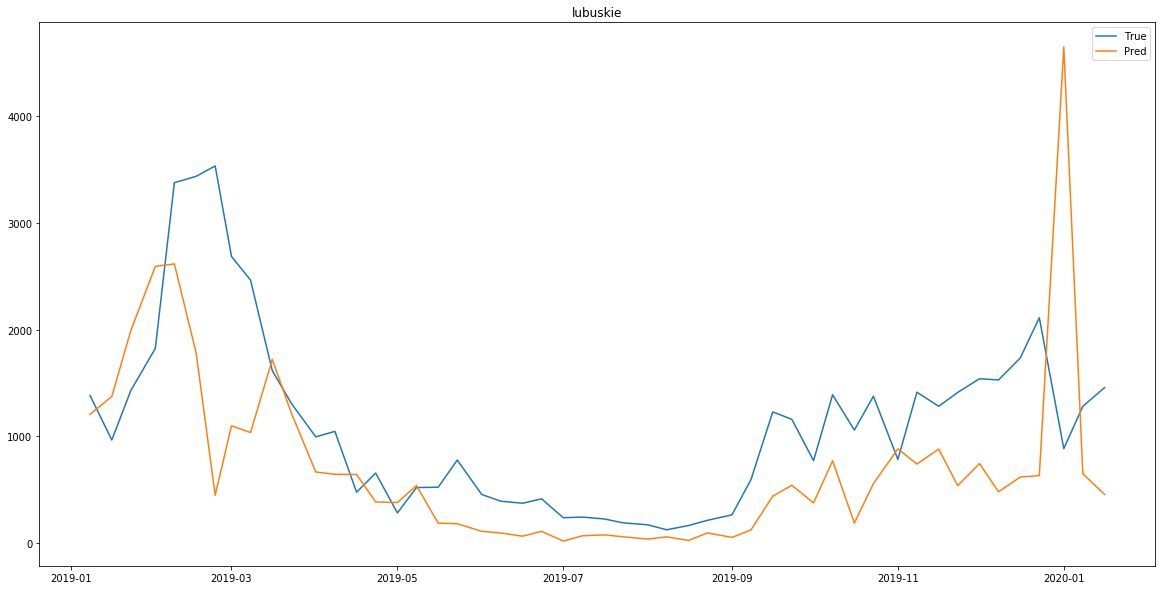

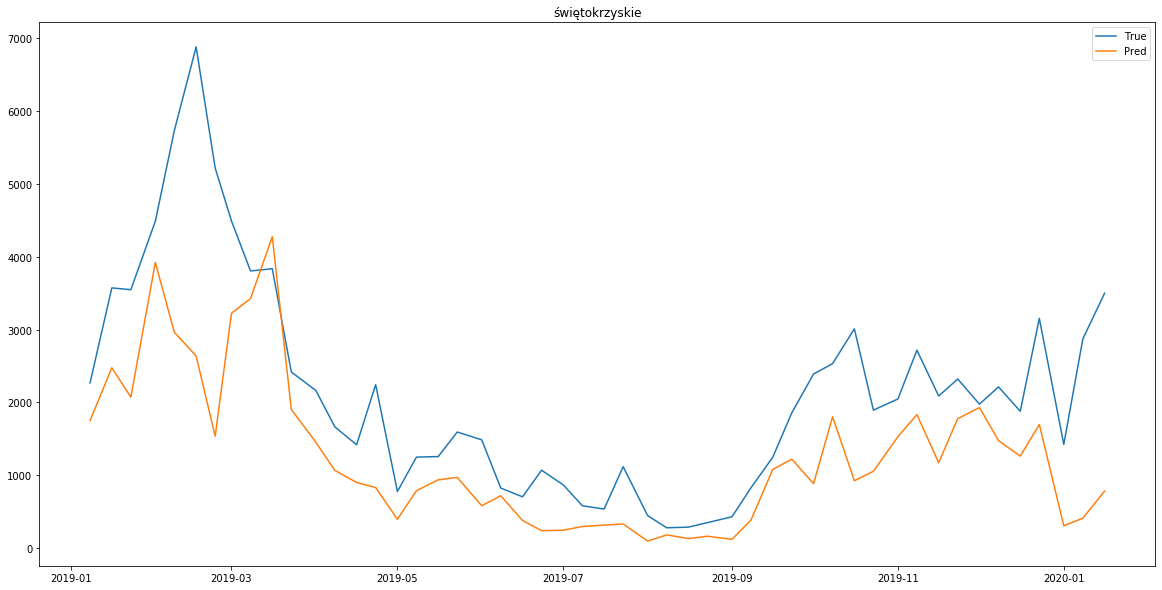

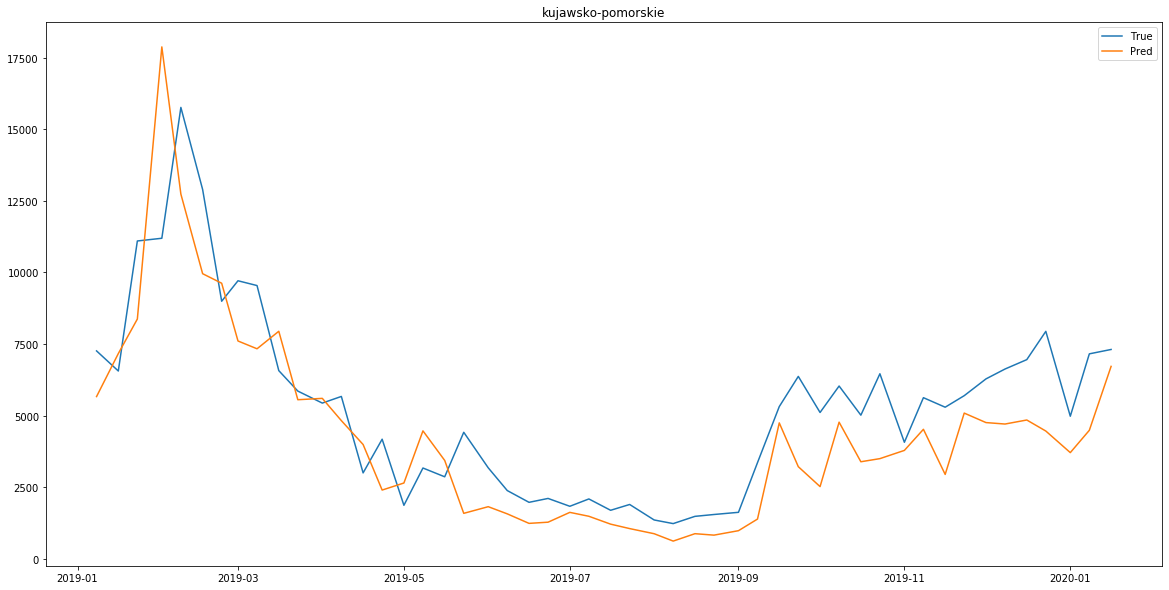

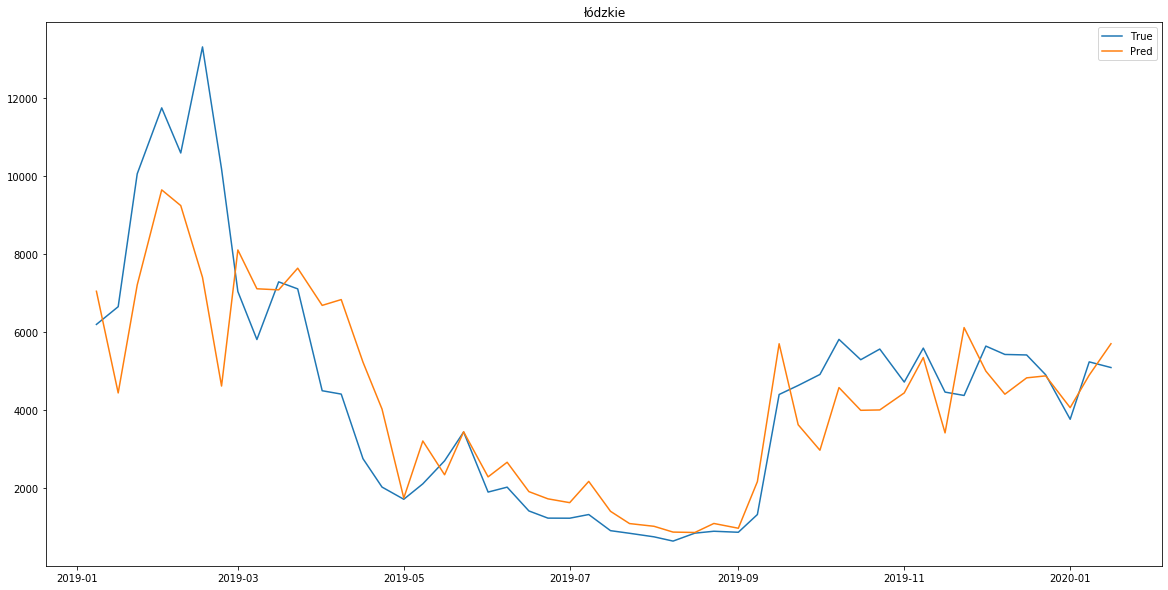

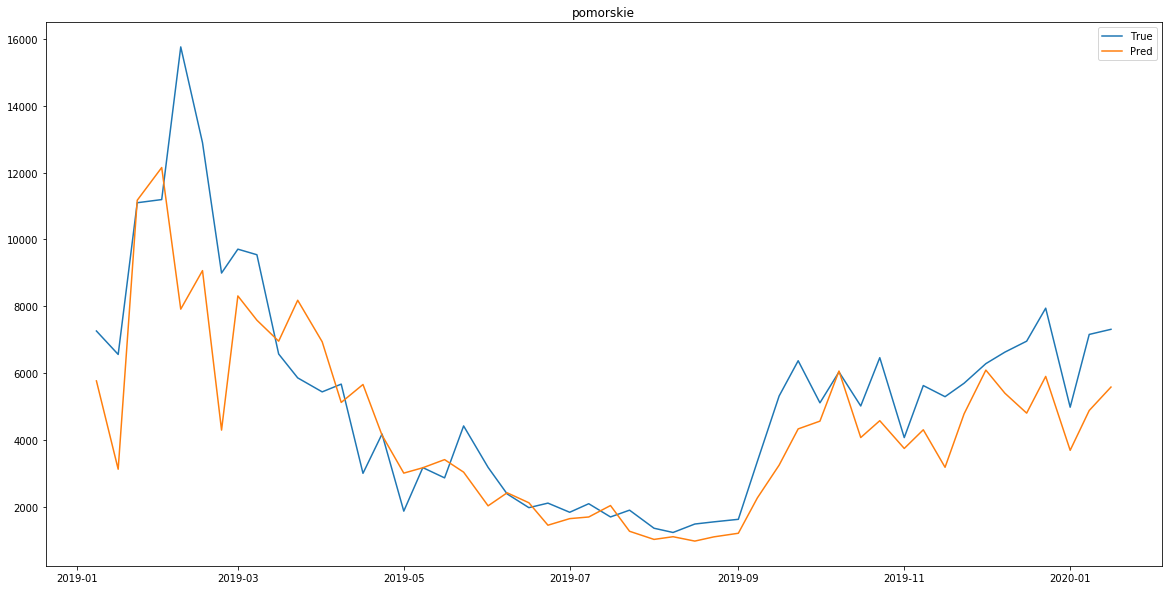

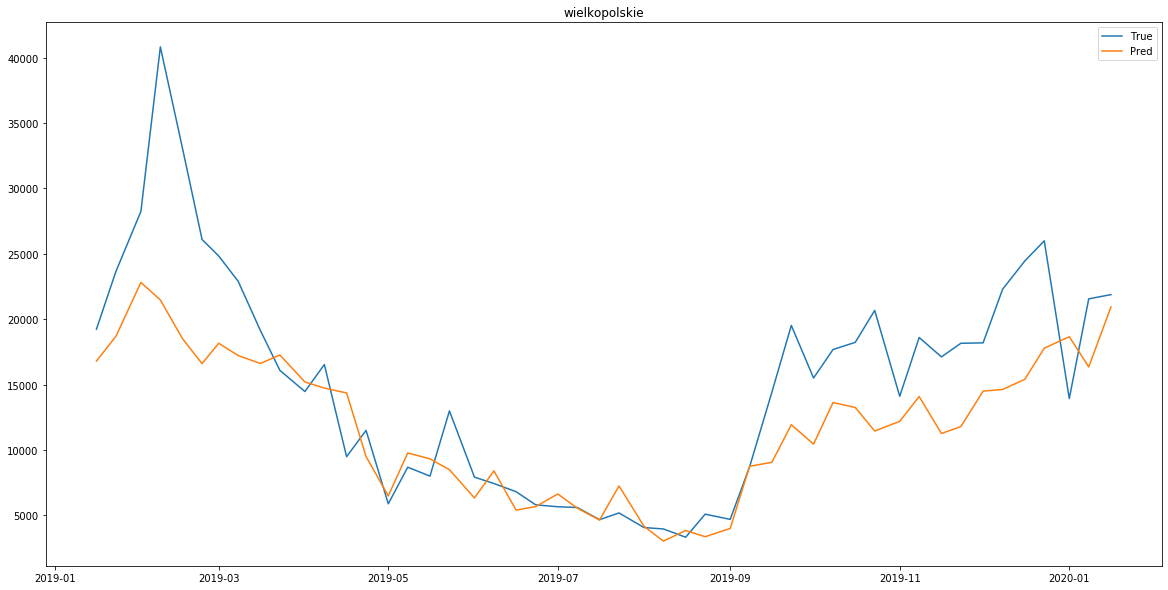

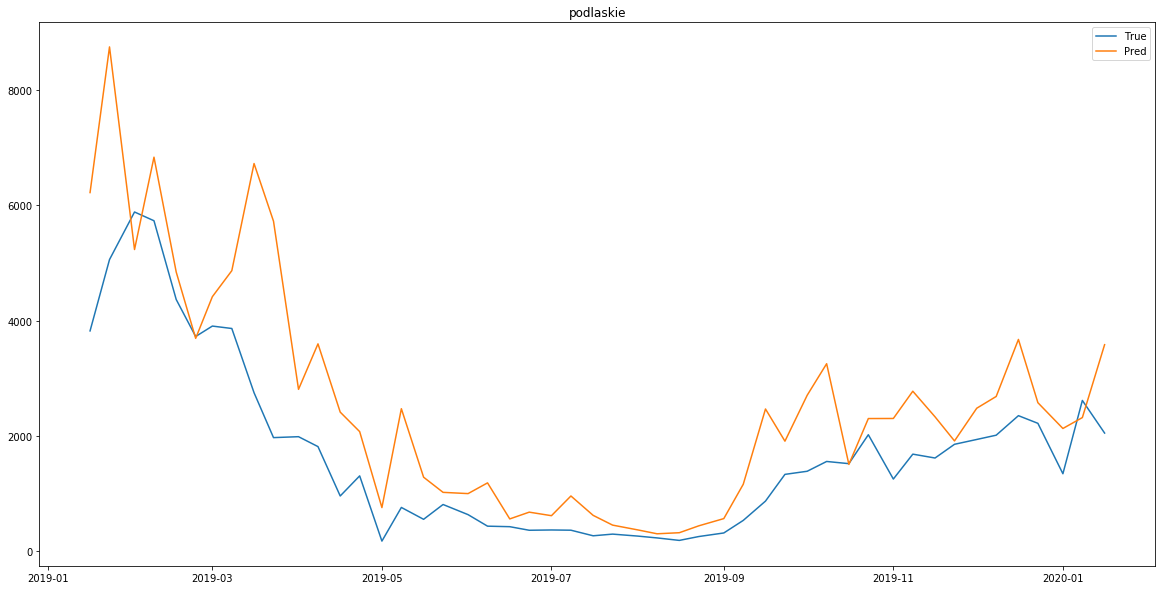

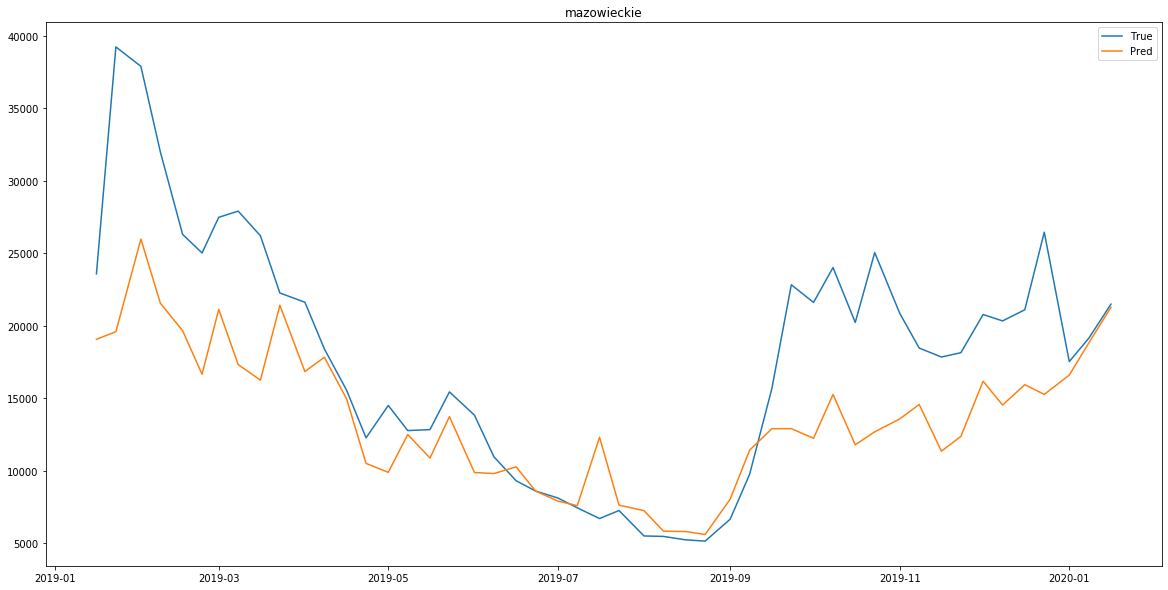

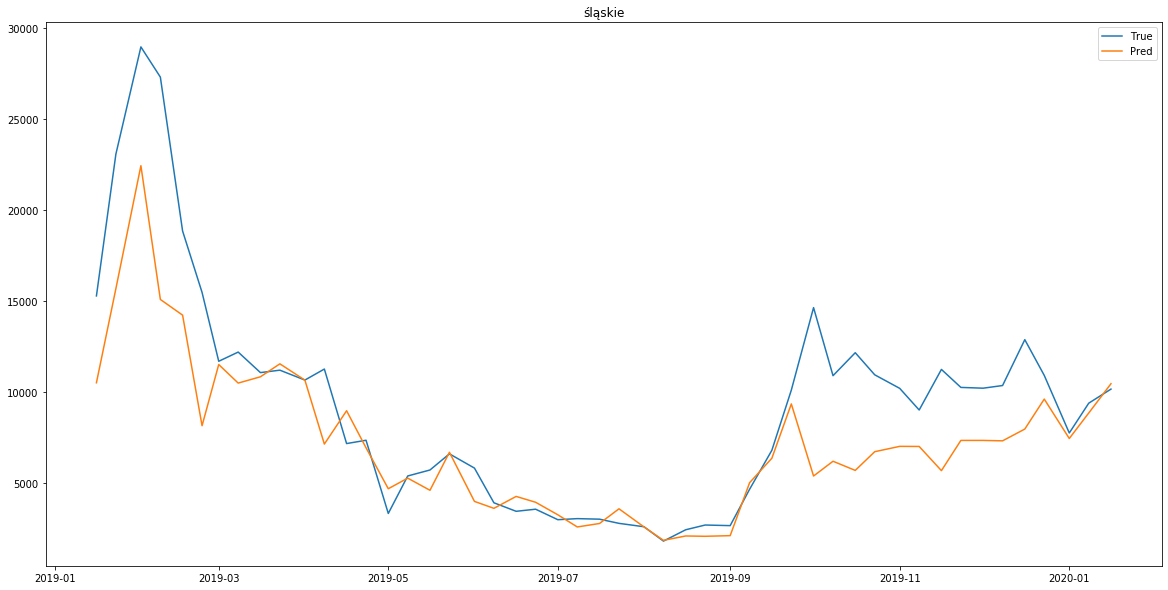

In [26]:
uni = df_test.Place.unique()

for i in range(len(uni)):
    plt.figure(figsize=(20,10))
    plt.plot(df_test["Date"][df_test.Place==uni[i]], df_test["Ill"][df_test.Place==uni[i]])
    plt.plot(df_test["Date"][df_test.Place==uni[i]], df_test["Ill_ex"][df_test.Place==uni[i]])
    plt.legend(["True", "Pred"])
    plt.title(uni[i])
    plt.show()